In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from denmarf import DensityEstimate
from denmarf.utils import plot_corner

from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture


In [2]:
data = pd.read_csv("sample_2C.csv", skiprows=6)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   distance       86 non-null     float64
 1   plx            86 non-null     float64
 2   s_plx          86 non-null     float64
 3   q_obs          86 non-null     float64
 4   s_q            86 non-null     float64
 5   u_obs          86 non-null     float64
 6   s_u            86 non-null     float64
 7   plx_true       86 non-null     float64
 8   q_true         86 non-null     float64
 9   u_true         86 non-null     float64
 10  distance_true  86 non-null     float64
dtypes: float64(11)
memory usage: 7.5 KB


In [5]:
data.head()

,distance,plx,s_plx,q_obs,s_q,u_obs,s_u,plx_true,q_true,u_true,distance_true
0,190.368327,5.252975,0.02,-0.001244,0.001003,0.000201,0.001003,5.28,0.000000,0.00000,189.393939
1,188.893397,5.293991,0.02,0.000224,0.001004,0.000758,0.001004,5.28,0.000000,0.00000,189.393939
2,189.953108,5.264457,0.02,0.000430,0.001009,0.001078,0.001009,5.28,0.000000,0.00000,189.393939
3,191.664104,5.217461,0.02,-0.000138,0.001013,-0.000478,0.001013,5.24,0.000000,0.00000,190.839695
4,518.598438,1.928274,0.02,0.017333,0.001028,-0.008440,0.001028,1.91,0.018031,-0.00865,523.560209


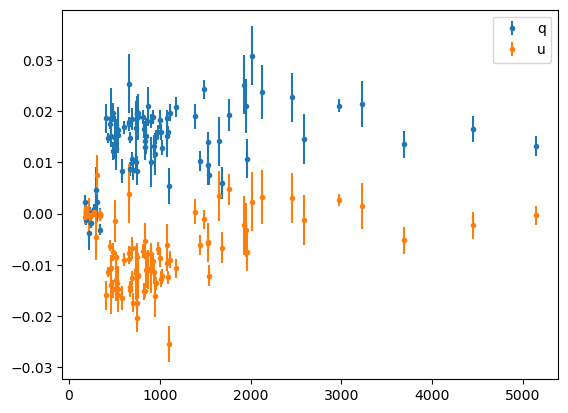

In [6]:
plt.errorbar(data["distance"], data["q_obs"], data["s_q"], ls='', marker='.', label="q")
plt.errorbar(data["distance"], data["u_obs"], data["s_u"], ls='', marker='.', label="u")
plt.legend()
plt.show()


# Not considering errors for now

In [7]:
nfde_q = DensityEstimate().fit(data[["distance","q_obs"]])
nfde_q.save("2C_nfde_q.pkl")

current average log likelihood: -4.573: 100%|██████████| 1000/1000 [06:54<00:00,  2.41it/s]

best average log likelihood: -4.498


In [8]:
nfde_u = DensityEstimate().fit(data[["distance","u_obs"]])
nfde_u.save("2C_nfde_u.pkl")

current average log likelihood: -5.723: 100%|██████████| 1000/1000 [06:20<00:00,  2.63it/s]

best average log likelihood: -3.889


In [9]:
import torch
nfde_q = torch.load("2C_nfde_q.pkl", weights_only=False)
nfde_u = torch.load("2C_nfde_u.pkl", weights_only=False)

In [10]:
N = 100
x = np.linspace(0,5000, N)
y = np.linspace(-0.01, 0.02, N)
XX, YY = np.meshgrid(x,y)
XY = np.column_stack((XX.ravel(), YY.ravel()))

Zq = nfde_q.score_samples(XY)
Zq = Zq.reshape(N,N)
Zu = nfde_u.score_samples(XY)
Zu = Zu.reshape(N,N)

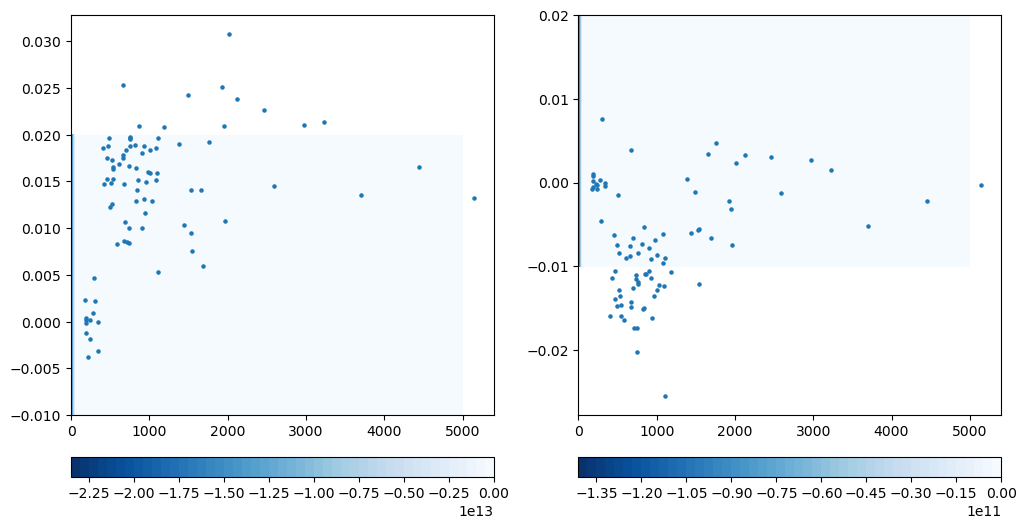

In [11]:
fig, ax = plt.subplots(2,2, figsize=[12,6], height_ratios=[20,1])
cf1 = ax[0,0].contourf(XX, YY, Zq, levels=50, cmap="Blues_r")
ax[0,0].scatter(data["distance"], data["q_obs"], s=5)
cf2 = ax[0,1].contourf(XX, YY, Zu, levels=50, cmap="Blues_r")
ax[0,1].scatter(data["distance"], data["u_obs"], s=5)

plt.colorbar(cf1, cax=ax[1,0], orientation="horizontal")
plt.colorbar(cf2, cax=ax[1,1], orientation="horizontal")
plt.show()


# KDE

In [12]:
kde_q = KernelDensity(kernel='gaussian', bandwidth='scott').fit(data[["distance","q_obs"]])
kde_u = KernelDensity(kernel='gaussian', bandwidth='scott').fit(data[["distance","u_obs"]])


In [13]:
Zkde_q = kde_q.score_samples(XY)
Zkde_q = Zkde_q.reshape(N,N)
Zkde_u = kde_u.score_samples(XY)
Zkde_u = Zkde_u.reshape(N,N)


/home/kopty/.miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/home/kopty/.miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(


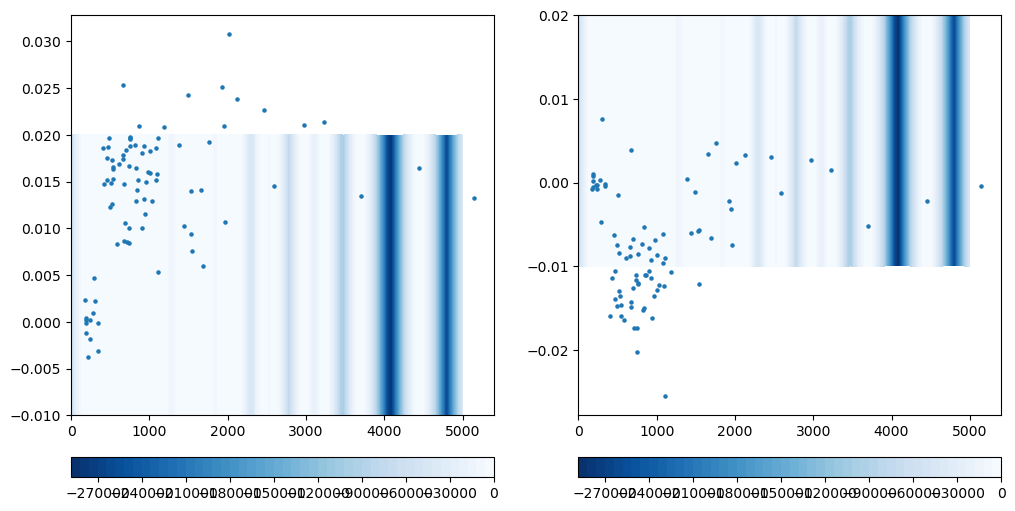

In [14]:
fig, ax = plt.subplots(2,2, figsize=[12,6], height_ratios=[20,1])
cf1 = ax[0,0].contourf(XX, YY, Zkde_q, levels=50, cmap="Blues_r")
ax[0,0].scatter(data["distance"], data["q_obs"], s=5)
cf2 = ax[0,1].contourf(XX, YY, Zkde_u, levels=50, cmap="Blues_r")
ax[0,1].scatter(data["distance"], data["u_obs"], s=5)

plt.colorbar(cf1, cax=ax[1,0], orientation="horizontal")
plt.colorbar(cf2, cax=ax[1,1], orientation="horizontal")
plt.show()
